In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_three_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [10]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300
convBlocks = 9

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

block = embedding_dropout
for currentBlock in range(convBlocks):
  block = one_by_three_cnn(filtersNumber, block)
  if(currentBlock < convBlocks-1):
    block = MaxPooling1D()(block)
  
features = yoon_kim_feature_extractor(filtersNumber, block)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [11]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 20384/102124 [====>.........................] - ETA: 4:33 - loss: 0.2302 - acc: 0.9155

 56672/102124 [===============>..............] - ETA: 2:23 - loss: 0.1320 - acc: 0.9521

 92896/102124 [==========================>...] - ETA: 28s - loss: 0.1056 - acc: 0.9618

102124/102124 [==============================] - 336s 3ms/step - loss: 0.1017 - acc: 0.9634 - val_loss: 0.0542 - val_acc: 0.9807
Epoch 2/32
 10304/102124 [==>...........................] - ETA: 4:38 - loss: 0.0607 - acc: 0.9777

 49664/102124 [=============>................] - ETA: 2:38 - loss: 0.0614 - acc: 0.9777

 87200/102124 [========================>.....] - ETA: 45s - loss: 0.0602 - acc: 0.9782

102124/102124 [==============================] - 328s 3ms/step - loss: 0.0599 - acc: 0.9783 - val_loss: 0.0540 - val_acc: 0.9803
roc-auc: 0.9745 - roc-auc_val: 0.9727                                                                                                    
Epoch 3/32
  4992/102124 [>.............................] - ETA: 4:52 - loss: 0.0576 - acc: 0.9804

 40960/102124 [===========>..................] - ETA: 3:04 - loss: 0.0568 - acc: 0.9796

 77760/102124 [=====================>........] - ETA: 1:13 - loss: 0.0570 - acc: 0.9795

102124/102124 [==============================] - 327s 3ms/step - loss: 0.0568 - acc: 0.9795 - val_loss: 0.0479 - val_acc: 0.9820
Epoch 4/32
  4544/102124 [>.............................] - ETA: 4:54 - loss: 0.0514 - acc: 0.9810

 40704/102124 [==========>...................] - ETA: 3:04 - loss: 0.0550 - acc: 0.9796

 79136/102124 [======================>.......] - ETA: 1:09 - loss: 0.0537 - acc: 0.9802

102124/102124 [==============================] - 325s 3ms/step - loss: 0.0538 - acc: 0.9802 - val_loss: 0.0571 - val_acc: 0.9815
roc-auc: 0.9783 - roc-auc_val: 0.974                                                                                                    
Epoch 5/32
  3168/102124 [..............................] - ETA: 4:56 - loss: 0.0511 - acc: 0.9802

 38528/102124 [==========>...................] - ETA: 3:11 - loss: 0.0515 - acc: 0.9808

 75840/102124 [=====================>........] - ETA: 1:19 - loss: 0.0515 - acc: 0.9808

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0518 - acc: 0.9808 - val_loss: 0.0490 - val_acc: 0.9818

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
  2720/102124 [..............................] - ETA: 5:02 - loss: 0.0466 - acc: 0.9827

 38688/102124 [==========>...................] - ETA: 3:11 - loss: 0.0508 - acc: 0.9813

 78880/102124 [======================>.......] - ETA: 1:10 - loss: 0.0504 - acc: 0.9812

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0501 - acc: 0.9813 - val_loss: 0.0481 - val_acc: 0.9820
roc-auc: 0.9797 - roc-auc_val: 0.9745                                                                                                    
Epoch 7/32
  2976/102124 [..............................] - ETA: 4:58 - loss: 0.0509 - acc: 0.9807

 40096/102124 [==========>...................] - ETA: 3:06 - loss: 0.0489 - acc: 0.9819

 76416/102124 [=====================>........] - ETA: 1:17 - loss: 0.0491 - acc: 0.9816

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0490 - acc: 0.9816 - val_loss: 0.0478 - val_acc: 0.9820
Epoch 8/32
  3840/102124 [>.............................] - ETA: 4:57 - loss: 0.0484 - acc: 0.9810

 42080/102124 [===========>..................] - ETA: 3:00 - loss: 0.0470 - acc: 0.9823

 80000/102124 [======================>.......] - ETA: 1:06 - loss: 0.0470 - acc: 0.9823

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0473 - acc: 0.9822 - val_loss: 0.0473 - val_acc: 0.9823
roc-auc: 0.9816 - roc-auc_val: 0.975                                                                                                    
Epoch 9/32
  3232/102124 [..............................] - ETA: 5:01 - loss: 0.0462 - acc: 0.9828

 39680/102124 [==========>...................] - ETA: 3:09 - loss: 0.0468 - acc: 0.9822

 75872/102124 [=====================>........] - ETA: 1:19 - loss: 0.0466 - acc: 0.9824

102124/102124 [==============================] - 329s 3ms/step - loss: 0.0461 - acc: 0.9826 - val_loss: 0.0460 - val_acc: 0.9827
Epoch 10/32
  3584/102124 [>.............................] - ETA: 4:58 - loss: 0.0446 - acc: 0.9823

 39040/102124 [==========>...................] - ETA: 3:11 - loss: 0.0461 - acc: 0.9824

 74656/102124 [====================>.........] - ETA: 1:23 - loss: 0.0457 - acc: 0.9825

102124/102124 [==============================] - 328s 3ms/step - loss: 0.0452 - acc: 0.9827 - val_loss: 0.0477 - val_acc: 0.9821
roc-auc: 0.9826 - roc-auc_val: 0.9752                                                                                                    
Epoch 11/32
  1984/102124 [..............................] - ETA: 5:03 - loss: 0.0425 - acc: 0.9842

 42880/102124 [===========>..................] - ETA: 2:59 - loss: 0.0445 - acc: 0.9831

 83456/102124 [=======================>......] - ETA: 56s - loss: 0.0444 - acc: 0.9830

102124/102124 [==============================] - 327s 3ms/step - loss: 0.0444 - acc: 0.9831 - val_loss: 0.0473 - val_acc: 0.9826
Epoch 12/32
  6720/102124 [>.............................] - ETA: 4:47 - loss: 0.0452 - acc: 0.9825

 43936/102124 [===========>..................] - ETA: 2:54 - loss: 0.0430 - acc: 0.9835

 85280/102124 [========================>.....] - ETA: 50s - loss: 0.0435 - acc: 0.9833

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0434 - acc: 0.9834 - val_loss: 0.0472 - val_acc: 0.9825
roc-auc: 0.9837 - roc-auc_val: 0.9749                                                                                                    
Epoch 13/32
  4576/102124 [>.............................] - ETA: 4:53 - loss: 0.0470 - acc: 0.9816

 40544/102124 [==========>...................] - ETA: 3:04 - loss: 0.0433 - acc: 0.9833

 81376/102124 [======================>.......] - ETA: 1:02 - loss: 0.0426 - acc: 0.9836

102124/102124 [==============================] - 325s 3ms/step - loss: 0.0427 - acc: 0.9836 - val_loss: 0.0459 - val_acc: 0.9827
Epoch 14/32
  5504/102124 [>.............................] - ETA: 4:51 - loss: 0.0377 - acc: 0.9855

 49216/102124 [=============>................] - ETA: 2:39 - loss: 0.0424 - acc: 0.9835

 85056/102124 [=======================>......] - ETA: 51s - loss: 0.0418 - acc: 0.9838

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0420 - acc: 0.9838 - val_loss: 0.0459 - val_acc: 0.9827
roc-auc: 0.9847 - roc-auc_val: 0.9754                                                                                                    
Epoch 15/32
  4512/102124 [>.............................] - ETA: 4:52 - loss: 0.0381 - acc: 0.9854

 44320/102124 [============>.................] - ETA: 2:53 - loss: 0.0407 - acc: 0.9840

 81472/102124 [======================>.......] - ETA: 1:02 - loss: 0.0412 - acc: 0.9839

102124/102124 [==============================] - 325s 3ms/step - loss: 0.0409 - acc: 0.9840 - val_loss: 0.0463 - val_acc: 0.9828
Epoch 16/32
  5728/102124 [>.............................] - ETA: 4:52 - loss: 0.0409 - acc: 0.9840

 42144/102124 [===========>..................] - ETA: 3:01 - loss: 0.0410 - acc: 0.9839

 79136/102124 [======================>.......] - ETA: 1:09 - loss: 0.0404 - acc: 0.9843

102124/102124 [==============================] - 326s 3ms/step - loss: 0.0406 - acc: 0.9842 - val_loss: 0.0457 - val_acc: 0.9829
roc-auc: 0.9853 - roc-auc_val: 0.9753                                                                                                    
Epoch 17/32
  3136/102124 [..............................] - ETA: 4:53 - loss: 0.0369 - acc: 0.9849

 44768/102124 [============>.................] - ETA: 2:51 - loss: 0.0395 - acc: 0.9844

 84800/102124 [=======================>......] - ETA: 51s - loss: 0.0398 - acc: 0.9844

102124/102124 [==============================] - 323s 3ms/step - loss: 0.0399 - acc: 0.9844 - val_loss: 0.0452 - val_acc: 0.9829
Epoch 18/32
  7296/102124 [=>............................] - ETA: 4:43 - loss: 0.0403 - acc: 0.9847

 43680/102124 [===========>..................] - ETA: 2:54 - loss: 0.0389 - acc: 0.9850

 82144/102124 [=======================>......] - ETA: 59s - loss: 0.0391 - acc: 0.9848

102124/102124 [==============================] - 324s 3ms/step - loss: 0.0393 - acc: 0.9847 - val_loss: 0.0456 - val_acc: 0.9828
roc-auc: 0.9859 - roc-auc_val: 0.9756                                                                                                    
Epoch 19/32
  3936/102124 [>.............................] - ETA: 4:50 - loss: 0.0406 - acc: 0.9838

 42880/102124 [===========>..................] - ETA: 2:56 - loss: 0.0392 - acc: 0.9848

 79072/102124 [======================>.......] - ETA: 1:08 - loss: 0.0392 - acc: 0.9847

102124/102124 [==============================] - 323s 3ms/step - loss: 0.0390 - acc: 0.9848 - val_loss: 0.0454 - val_acc: 0.9831

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.694652595091611e-05.
Epoch 20/32
  3744/102124 [>.............................] - ETA: 4:58 - loss: 0.0350 - acc: 0.9869

 40448/102124 [==========>...................] - ETA: 3:04 - loss: 0.0387 - acc: 0.9846

 79456/102124 [======================>.......] - ETA: 1:07 - loss: 0.0380 - acc: 0.9851

102124/102124 [==============================] - 323s 3ms/step - loss: 0.0383 - acc: 0.9850 - val_loss: 0.0457 - val_acc: 0.9830
roc-auc: 0.9862 - roc-auc_val: 0.975                                                                                                    
Epoch 21/32
  3264/102124 [..............................] - ETA: 4:56 - loss: 0.0366 - acc: 0.9851

 41696/102124 [===========>..................] - ETA: 3:00 - loss: 0.0373 - acc: 0.9853

 79392/102124 [======================>.......] - ETA: 1:08 - loss: 0.0380 - acc: 0.9851

102124/102124 [==============================] - 323s 3ms/step - loss: 0.0382 - acc: 0.9850 - val_loss: 0.0457 - val_acc: 0.9830
Epoch 22/32
  5152/102124 [>.............................] - ETA: 4:49 - loss: 0.0362 - acc: 0.9857

 42016/102124 [===========>..................] - ETA: 2:59 - loss: 0.0379 - acc: 0.9851

 80192/102124 [======================>.......] - ETA: 1:05 - loss: 0.0378 - acc: 0.9853

102124/102124 [==============================] - 322s 3ms/step - loss: 0.0379 - acc: 0.9852 - val_loss: 0.0460 - val_acc: 0.9831
roc-auc: 0.9864 - roc-auc_val: 0.9749                                                                                                    
Epoch 23/32
  3456/102124 [>.............................] - ETA: 4:54 - loss: 0.0354 - acc: 0.9858

 41984/102124 [===========>..................] - ETA: 2:58 - loss: 0.0370 - acc: 0.9857

 89504/102124 [=========================>....] - ETA: 37s - loss: 0.0371 - acc: 0.9856

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0374 - acc: 0.9855 - val_loss: 0.0455 - val_acc: 0.9831
Epoch 24/32
  9056/102124 [=>............................] - ETA: 4:36 - loss: 0.0390 - acc: 0.9847

 51744/102124 [==============>...............] - ETA: 2:29 - loss: 0.0376 - acc: 0.9854

 88992/102124 [=========================>....] - ETA: 38s - loss: 0.0375 - acc: 0.9853

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0372 - acc: 0.9854 - val_loss: 0.0458 - val_acc: 0.9832
roc-auc: 0.9868 - roc-auc_val: 0.9747                                                                                                    
Epoch 25/32
  5600/102124 [>.............................] - ETA: 4:45 - loss: 0.0375 - acc: 0.9854

 58944/102124 [================>.............] - ETA: 2:08 - loss: 0.0373 - acc: 0.9855

 97952/102124 [===========================>..] - ETA: 12s - loss: 0.0370 - acc: 0.9855

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0370 - acc: 0.9855 - val_loss: 0.0459 - val_acc: 0.9829
Epoch 26/32
 12192/102124 [==>...........................] - ETA: 4:27 - loss: 0.0374 - acc: 0.9850

 57664/102124 [===============>..............] - ETA: 2:11 - loss: 0.0372 - acc: 0.9855

102112/102124 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9856

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0368 - acc: 0.9856 - val_loss: 0.0463 - val_acc: 0.9829
roc-auc: 0.9872 - roc-auc_val: 0.9753                                                                                                    
Epoch 27/32
  8576/102124 [=>............................] - ETA: 4:39 - loss: 0.0377 - acc: 0.9857

 46752/102124 [============>.................] - ETA: 2:44 - loss: 0.0370 - acc: 0.9854

 85344/102124 [========================>.....] - ETA: 49s - loss: 0.0370 - acc: 0.9854

102124/102124 [==============================] - 321s 3ms/step - loss: 0.0366 - acc: 0.9857 - val_loss: 0.0458 - val_acc: 0.9829


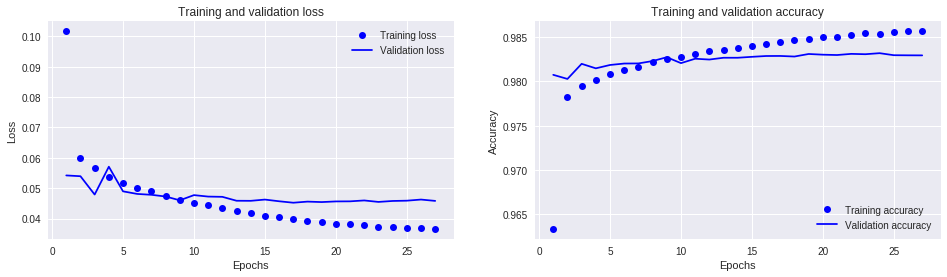

In [12]:
plot_history(history)

In [13]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 24s 767us/step
([0.04462836109779947, 0.9831688205388652], 0.978922132046438)
